In [1]:
import numpy as np
if not hasattr(np, 'typeDict'):
    np.typeDict = np.sctypeDict
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2025-03-13 01:13:14.369135: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 01:13:14.371248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 01:13:14.417361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 01:13:14.418434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 01:13:14.969114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

2.13.1


## 데이터

### 데이터 준비

In [2]:
import pandas as pd

# CSV 파일 경로
path = "/home/downtown/aiffel/transformer_chatbot/ChatbotData.csv"

# CSV 파일 읽기
df = pd.read_csv(path)

# 'Q' 컬럼은 질문, 'A' 컬럼은 답변으로 분리
questions = df['Q'].tolist()
answers = df['A'].tolist()

# 데이터 확인
print(questions[:5])
print(answers[:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


### 데이터 전처리

In [3]:
# Q. 전처리 함수를 만들어 보세요. 아래 기능을 추가해주세요.
def preprocess_sentence(sentence):
    # 대문자를 소문자로 변환
    # 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅎ가-힣.,!?]", " ", sentence)

    return sentence

In [4]:
questions = list(map(preprocess_sentence, questions))
answers = list(map(preprocess_sentence, answers))

# 데이터 확인
print(questions[:5])
print(answers[:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


## 토큰화
### 토크나이저 준비
토큰화에는 KoNLPy의 mecab 클래스를 사용   

아래 조건을 만족하는 build_corpus() 함수 구현   

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다. 
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다. 
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다. 
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다. 
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요! 

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장

In [5]:
from konlpy.tag import Okt

tokenizer = Okt().morphs

def build_corpus(sentences, tokenizer, max_len=50):
    """
    문장 데이터를 토큰화하고, 길이 제한 및 중복 제거하여 정제하는 함수

    :param sentences: 입력 문장 리스트
    :param tokenizer: 사용할 토크나이저 (예: Okt().morphs)
    :param max_len: 최대 토큰 길이 제한 (default: 50)
    :return: 토큰화된 문장 리스트 (중복 제거됨)
    """
    processed_sentences = set()  # 중복 제거를 위해 set 사용
    tokenized_sentences = []

    for sentence in sentences:
        sentence = preprocess_sentence(sentence)  # 전처리 수행
        tokenized = tokenizer(sentence)  # 형태소 분석기 사용

        if len(tokenized) > max_len:
            continue  # 최대 길이를 초과하는 문장은 제외

        joined_sentence = " ".join(tokenized)
        if joined_sentence not in processed_sentences:  # 중복 제거
            processed_sentences.add(joined_sentence)
            tokenized_sentences.append(tokenized)

    return tokenized_sentences


In [6]:
# 토큰화
que_corpus = build_corpus(questions, tokenizer)
ans_corpus = build_corpus(answers, tokenizer)

print(que_corpus[:5])
print(ans_corpus[:5])

[['12시', '땡', '!'], ['1', '지망', '학교', '떨어졌어'], ['3', '박', '4일', '놀러', '가고', '싶다'], ['3', '박', '4일', '정도', '놀러', '가고', '싶다'], ['ppl', '심하네']]
[['하루', '가', '또', '가네요', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋죠', '.'], ['눈살', '이', '찌푸려지죠', '.'], ['다시', '새로', '사는', '게', '마음', '편해요', '.']]


## Augmentation
- Embedding을 활용한 Lexical Subsitution 구현
- gensim 라이브러리에 사전 훈련된 Embedding 모델 불러와 사용
- 대표적으로 사용되는 Embedding 모델인 `word2vec-google-news-300`은 용량이 너무 크기 때문에 적당한 사이즈 모델인 `glove-wiki-gigaword-300` 사용

In [11]:
!pip install --upgrade gensim==3.8.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 9.3 MB/s eta 0:00:0000:0100:01


In [7]:
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

In [8]:
from gensim.models import Word2Vec

# Gensim Word2Vec 모델 로드
ko_model_path = "/home/downtown/aiffel/transformer_chatbot/ko.bin"

wv = Word2Vec.load(ko_model_path)

# 단어 벡터만 추출 (KeyedVectors 형태로 변환)
wv = wv.wv

In [9]:
if hasattr(wv, 'vocab'):
    print("모델에 포함된 단어 개수:", len(wv.vocab.keys()))
    print("상위 10개 단어:", list(wv.vocab.keys())[:10])

모델에 포함된 단어 개수: 30185
상위 10개 단어: ['관위', '정어리', '유식론', '장로회', '춘추관', '도입부', '민병', '어렵', '매니저', '청담']


In [ ]:
# import random
# from tqdm import tqdm

# def lexical_sub(sentence, wv, top_n=5, sub_prob=0.3):
#     """
#     문장에서 랜덤한 단어 하나를 의미적으로 유사한 단어로 대체하여 데이터 증강 수행.
    
#     :param sentence: 원본 문장 (str)
#     :param wv: GloVe 등 사전 학습된 단어 임베딩 모델
#     :param top_n: 유사한 단어 후보 개수 (default: 5)
#     :param sub_prob: 단어 치환 확률 (0~1, default: 0.3)
#     :return: 치환된 문장 (원본과 동일하면 None 반환)
#     """
#     words = sentence.split()
    
#     # 치환할 단어를 랜덤 선택 (확률 기반)
#     if random.random() > sub_prob or not words:
#         return None  # 치환 확률이 낮거나 문장이 비어있으면 변경하지 않음
    
#     selected_tok = random.choice(words)  # 랜덤하게 하나의 단어 선택
    
#     try:
#         # 선택된 단어와 의미적으로 유사한 단어 중 하나 선택
#         similar_words = [w for w, _ in wv.most_similar(selected_tok, topn=top_n)]
#         new_word = random.choice(similar_words) if similar_words else selected_tok
#     except KeyError:
#         return None  # 선택된 단어가 Word2Vec 모델에 없으면 치환하지 않음

#     # 선택된 단어를 유사한 단어로 치환
#     new_sentence = " ".join([new_word if tok == selected_tok else tok for tok in words])
    
#     return new_sentence if new_sentence != sentence else None

In [25]:
# aug_que_corpus = []  # 질문 데이터 증강
# aug_ans_corpus = []  # 답변 데이터 증강

# for src, tgt in tqdm(zip(que_corpus, ans_corpus), total=len(que_corpus)):
#     # 질문(que_corpus)만 Augmentation하고 답변(ans_corpus)은 원본 유지
#     new_src = lexical_sub(" ".join(src), wv)  # 원본은 토큰 리스트이므로 문자열로 변환
#     if new_src is not None:
#         aug_que_corpus.append(new_src.split())  # Augmentation된 문장 추가
#         aug_ans_corpus.append(tgt)  # 원본 답변 유지
    
#     # 답변(ans_corpus)만 Augmentation하고 질문(que_corpus)은 원본 유지
#     new_tgt = lexical_sub(" ".join(tgt), wv)
#     if new_tgt is not None:
#         aug_que_corpus.append(src)  # 원본 질문 유지
#         aug_ans_corpus.append(new_tgt.split())  # Augmentation된 문장 추가
    
#     # 원본 데이터도 포함
#     aug_que_corpus.append(src)
#     aug_ans_corpus.append(tgt)


 67%|██████▋   | 7748/11644 [00:06<00:03, 1112.89it/s]


증강을 하다 말고 맘대로 끝낸다 ;

In [26]:
# print(f"\n데이터 크기: 원본 {len(que_corpus)} → 증강 후 {len(aug_que_corpus)}")

# print("aug_que")
# print(aug_que_corpus[:5])

# print("aug_ans")
# print(aug_ans_corpus[:5])



데이터 크기: 원본 11644 → 증강 후 10737
aug_que
[['12시', '땡', '!'], ['1', '지망', '강습소', '떨어졌어'], ['1', '지망', '학교', '떨어졌어'], ['3', '박', '4일', '놀러', '가고', '싶다'], ['3', '박', '4일', '정도', '놀러', '가고', '싶다']]
aug_ans
[['하루', '가', '또', '가네요', '.'], ['위로', '해', '드립니다', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋죠', '.'], ['눈살', '이', '찌푸려지죠', '.']]


오히려 증강 후 수가 더 적음

In [ ]:
# def lexical_sub(sentence, wv, top_n=5, sub_prob=0.3):
#     words = sentence.split()
    
#     # 치환할 단어를 랜덤 선택 (확률 기반)
#     if random.random() > sub_prob or not words:
#         return None
    
#     selected_tok = random.choice(words)  # 랜덤하게 하나의 단어 선택
    
#     try:
#         # 선택된 단어와 의미적으로 유사한 단어 중 하나 선택
#         similar_words = [w for w, _ in wv.most_similar(selected_tok, topn=top_n)]
#         new_word = random.choice(similar_words) if similar_words else selected_tok
#     except (KeyError, ValueError, IndexError):
#         return None  # 단어가 모델에 없거나 유사 단어가 없을 경우 무시

#     new_sentence = " ".join([new_word if tok == selected_tok else tok for tok in words])
#     return new_sentence if new_sentence != sentence else None


In [31]:
# aug_que_corpus = []
# aug_ans_corpus = []

# sub_prob = 0.7  # 70% 확률로 단어 교체

# for src, tgt in tqdm(zip(que_corpus, ans_corpus), total=len(que_corpus), leave=True):
#     new_src = lexical_sub(" ".join(src), wv, sub_prob=sub_prob)  # sub_prob 적용
#     new_tgt = lexical_sub(" ".join(tgt), wv, sub_prob=sub_prob)

#     if new_src is not None:
#         aug_que_corpus.append(new_src.split())
#         aug_ans_corpus.append(tgt)

#     if new_tgt is not None:
#         aug_que_corpus.append(src)
#         aug_ans_corpus.append(new_tgt.split())

#     aug_que_corpus.append(src)
#     aug_ans_corpus.append(tgt)


 67%|██████▋   | 7748/11644 [00:19<00:09, 396.82it/s]


In [32]:
# print(f"\n데이터 크기: 원본 {len(que_corpus)} → 증강 후 {len(aug_que_corpus)}")

# print("aug_que")
# print(aug_que_corpus[:5])

# print("aug_ans")
# print(aug_ans_corpus[:5])



데이터 크기: 원본 11644 → 증강 후 14665
aug_que
[['12시', '땡', '크레딧'], ['12시', '땡', '!'], ['1', '지망', '중고등학교', '떨어졌어'], ['1', '지망', '학교', '떨어졌어'], ['3', '박', '4일', '놀러', '가고', '싶다']]
aug_ans
[['하루', '가', '또', '가네요', '.'], ['하루', '가', '또', '가네요', '.'], ['위로', '해', '드립니다', '.'], ['위로', '해', '드립니다', '.'], ['여행', '이란', '언제나', '좋죠', '.']]


In [58]:
none_count_enc = 0
none_count_dec = 0

# 질문 데이터에서 None 발생 개수 확인
for src in que_corpus:
    if lexical_sub(" ".join(src), wv) is None:
        none_count_enc += 1

# 답변 데이터에서 None 발생 개수 확인
for tgt in ans_corpus:
    if lexical_sub(" ".join(tgt), wv) is None:
        none_count_dec += 1

print(f"질문 데이터에서 None 발생 개수: {none_count_enc}")
print(f"답변 데이터에서 None 발생 개수: {none_count_dec}")


질문 데이터에서 None 발생 개수: 9437
답변 데이터에서 None 발생 개수: 6623


기존 증강 코드를 보면 OOV 일 경우 None을 반환하는데 원본 문장을 반환하도록 증강 코드 수정

In [10]:
def lexical_sub(sentence, wv, top_n=5, sub_prob=0.3):
    words = sentence.split()
    
    # 치환할 단어를 랜덤 선택 (확률 기반)
    if random.random() > sub_prob or not words:
        return None
    
    selected_tok = random.choice(words)  # 랜덤하게 하나의 단어 선택
    
    try:
        # 선택된 단어와 의미적으로 유사한 단어 중 하나 선택
        similar_words = [w for w, _ in wv.most_similar(selected_tok, topn=top_n)]
        new_word = random.choice(similar_words) if similar_words else selected_tok
    except (KeyError, ValueError, IndexError):
        return sentence  # 단어가 모델에 없거나 유사 단어가 없을 경우 원본 문장 반환환

    new_sentence = " ".join([new_word if tok == selected_tok else tok for tok in words])
    return new_sentence if new_sentence != sentence else None


In [11]:
aug_que_corpus = []
aug_ans_corpus = []

sub_prob = 0.7  # 70% 확률로 단어 교체

for src, tgt in tqdm(zip(que_corpus, ans_corpus), total=len(que_corpus), leave=True):
    new_src = lexical_sub(" ".join(src), wv, sub_prob=sub_prob)  # sub_prob 적용
    new_tgt = lexical_sub(" ".join(tgt), wv, sub_prob=sub_prob)

    if new_src is not None:
        aug_que_corpus.append(new_src.split())
        aug_ans_corpus.append(tgt)

    if new_tgt is not None:
        aug_que_corpus.append(src)
        aug_ans_corpus.append(new_tgt.split())

    aug_que_corpus.append(src)
    aug_ans_corpus.append(tgt)


  0%|          | 0/11644 [00:00<?, ?it/s]

In [12]:
print(f"\n데이터 크기: 원본 {len(que_corpus)} → 증강 후 {len(aug_que_corpus)}")

print("aug_que")
print(aug_que_corpus[:5])

print("aug_ans")
print(aug_ans_corpus[:5])



데이터 크기: 원본 11644 → 증강 후 18732
aug_que
[['12시', 'ㅋ', '!'], ['12시', '땡', '!'], ['12시', '땡', '!'], ['1', '지망', '전문학교', '떨어졌어'], ['1', '지망', '학교', '떨어졌어']]
aug_ans
[['하루', '가', '또', '가네요', '.'], ['하루', '가', '또', '가네요', '.'], ['하루', '가', '또', '가네요', '.'], ['위로', '해', '드립니다', '.'], ['꿇', '해', '드립니다', '.']]


## 데이터 벡터화

타겟 데이터인 ans_corpus 에 \<start\> 토큰과 \<end\> 토큰 추가 후 벡터화 진행

In [13]:
aug_ans_corpus = [["<start>"] + ans + ["<end>"] for ans in aug_ans_corpus]

In [14]:
print(aug_ans_corpus[:3])

[['<start>', '하루', '가', '또', '가네요', '.', '<end>'], ['<start>', '하루', '가', '또', '가네요', '.', '<end>'], ['<start>', '하루', '가', '또', '가네요', '.', '<end>']]


In [15]:
from collections import Counter

# 전체 데이터 통합
all_sentences = aug_que_corpus + aug_ans_corpus  # 질문 + 답변 데이터 결합

# 단어 사전 생성
word_counts = Counter(token for sentence in all_sentences for token in sentence)
vocab = ["<pad>", "<unk>"] + sorted(word_counts.keys())  # <pad>, <unk> 추가

# 단어 → 인덱스 매핑
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# 사전 크기 확인
print(f"단어 사전 크기: {len(vocab)}")
print(f"샘플 단어 10개: {list(word2idx.keys())[:10]}")


단어 사전 크기: 12559
샘플 단어 10개: ['<pad>', '<unk>', '!', '!!', '!!!', '!?', ',', ',,', ',.', '.']


In [16]:
## 단어를 벡터화하여 모델 입력 데이터로 변환

# 문장을 인덱스 벡터로 변환하는 함수
def tokenize(sentences, word2idx):
    return [[word2idx.get(token, word2idx["<unk>"]) for token in sentence] for sentence in sentences]

# 질문과 답변 데이터를 인덱스로 변환
enc_train = tokenize(aug_que_corpus, word2idx)  # 인코더 입력
dec_train = tokenize(aug_ans_corpus, word2idx)  # 디코더 입력

# 데이터 크기 확인
print(f"enc_train 샘플 크기 : {len(enc_train)}")
print(f"dec_train 샘플 크기 : {len(dec_train)}")

# 샘플 확인
print("인코더 입력 샘플 :", enc_train[:2])
print("디코더 입력 샘플 :", dec_train[:2])

# 각 데이터셋의 최대 길이 확인
enc_max_len = max(len(seq) for seq in enc_train)
dec_max_len = max(len(seq) for seq in dec_train)

# 최대 길이 확인
print(f"enc_train max len : {enc_max_len}")
print(f"dec_train max len : {dec_max_len}")

enc_train 샘플 크기 : 18732
dec_train 샘플 크기 : 18732
인코더 입력 샘플 : [[27, 103, 2], [27, 3392, 2]]
디코더 입력 샘플 : [[76, 11663, 109, 3474, 130, 9, 75], [76, 11663, 109, 3474, 130, 9, 75]]
enc_train max len : 17
dec_train max len : 33


In [17]:
# 한 문장의 토큰 길이가 각각의 max len이 되도록 설정
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(enc_train, maxlen=enc_max_len, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(dec_train, maxlen=dec_max_len, padding='post')

In [18]:
# 훈련에 사용할 수 있도록 각 데이터를 묶어 배치 크기의 텐서로 만들어 줌

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

2025-03-13 01:15:04.014603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 01:15:04.061222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 트랜스포머 구현
Encoder와 Decoder 각각의 Embedding과 출력층의 Linear, 총 3개의 레이어가 Weight를 공유할 수 있도록

##### Positional Encoding

In [19]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

##### 마스크 생성

In [20]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

##### Multi-head Attention

In [21]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

##### Position-wise Feed Forward Network

In [22]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

##### Encoder Layer

In [23]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

##### Decoder Layer

In [24]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

##### Encoder

In [25]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

##### Decoder

In [26]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

##### Transformer 전체 모델 조립

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_ff = d_ff
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

##### 모델 인스턴스 생성

In [28]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=len(vocab),
    tgt_vocab_size=len(vocab),
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

##### Learning Rate Scheduler

In [29]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    WARMUP_STEPS = 3000
    def __init__(self, d_model, warmup_steps=WARMUP_STEPS):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.pow(step, -0.5)
        arg2 = step * tf.math.pow(self.warmup_steps, -1.5)
        
        return tf.math.pow(self.d_model, -0.5) * tf.math.minimum(arg1, arg2)

##### Learning Rate & Optimizer

In [30]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

##### Loss Function

In [31]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##### Train Step

In [32]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### Training

상헌님 꿀팁 : 저 방금 훈련 돌려봤는데 레이어 개수 3개로 늘리니까 training loss가 훨씬 잘 떨어집니다 validation loss는 안 찍어봤는데 일단 훈련데이터에 대해선 확실히 효과있었습니다

---
### 1차 실험

In [33]:
# Q. 위의 코드를 활용하여 모델을 훈련시켜봅시다!
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count, desc=f"Epoch {epoch+1}")
    
    for batch, (src, tgt) in enumerate(train_dataset):
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += loss
        tqdm_bar.set_description(f"Epoch {epoch+1} Loss: {loss.numpy():.4f}")
        tqdm_bar.update(1)
    
    tqdm_bar.close()
    print(f"Epoch {epoch+1} 평균 손실: {(total_loss / dataset_count):.4f}")

Epoch 1:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch 1 평균 손실: 6.6297


Epoch 2:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch 2 평균 손실: 5.0305


Epoch 3:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch 3 평균 손실: 4.2132


In [35]:
# 챗봇 응답 생성 함수 (greedy decoding)
def chat_response(sentence, model, word2idx, idx2word, max_len_enc, max_len_dec):
    # 입력이 리스트라면 문자열로 변환
    if isinstance(sentence, list):
        sentence = " ".join(sentence)

    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    # 간단한 토큰화 (이미 전처리된 문장은 공백 기준 분리)
    tokens = sentence.split()
    # 단어를 인덱스로 변환 (없으면 <unk>로 처리)
    input_ids = [word2idx.get(token, word2idx["<unk>"]) for token in tokens]
    # 인코더 입력 벡터로 패딩 (배치 크기 1)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences([input_ids], maxlen=max_len_enc, padding='post')
    encoder_input = tf.convert_to_tensor(input_ids)
    
    # 디코더 입력 초기화 (<start> 토큰)
    decoder_input = [word2idx["<start>"]]
    
    for i in range(max_len_dec):
        # 현재 디코더 입력을 max_len_dec에 맞춰 패딩
        dec_input_padded = tf.keras.preprocessing.sequence.pad_sequences([decoder_input], maxlen=max_len_dec, padding='post')
        dec_input_tensor = tf.convert_to_tensor(dec_input_padded)
        
        # 마스크 생성 (generate_masks 함수가 이미 정의되어 있다고 가정)
        enc_mask, combined_mask, dec_mask = generate_masks(encoder_input, dec_input_tensor)
        
        # 모델 예측 수행
        predictions, _, _, _ = model(encoder_input, dec_input_tensor, enc_mask, combined_mask, dec_mask)
        # predictions shape: (batch, sequence_length, vocab_size)
        # 현재 단계: decoder_input의 길이 - 1 (마지막 토큰의 위치)
        predicted_id = tf.argmax(predictions[0, len(decoder_input)-1]).numpy()
        
        # <end> 토큰이면 종료
        if predicted_id == word2idx["<end>"]:
            break
        
        # 예측된 토큰을 디코더 입력에 추가
        decoder_input.append(predicted_id)
    
    # 디코더 입력 중, 첫 번째 <start> 토큰 제외하고 단어로 변환
    response_tokens = [idx2word[idx] for idx in decoder_input[1:]]
    return " ".join(response_tokens)

In [36]:
# 인코더, 디코더의 최대 길이
enc_max_len = enc_ndarray.shape[1]
dec_max_len = dec_ndarray.shape[1]

# 테스트용 예문
test_queries = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

# 챗봇 응답 생성
responses = [chat_response(query, transformer, word2idx, idx2word, enc_max_len, dec_max_len) 
             for query in test_queries]

# 제출 형식에 맞게 결과 출력
print("\nTranslations")
for i, response in enumerate(responses, 1):
    print(f"> {i}. {response} <end>")

# 하이퍼파라미터 출력 함수
def print_hyperparameters(model):
    print("\nHyperparameters")
    print("> n_layers:", model.n_layers)
    print("> d_model:", model.d_model.numpy() if hasattr(model.d_model, "numpy") else model.d_model)
    print("> n_heads:", model.n_heads)
    print("> d_ff:", model.d_ff)
    print("> dropout:", model.do.rate)

print_hyperparameters(transformer)

# 훈련 파라미터 (학습 시 사용한 값)

print("\nTraining Parameters")
print("> Warmup Steps:", LearningRateScheduler.WARMUP_STEPS)
print("> Batch Size:", BATCH_SIZE)
print("> Epoch At:", EPOCHS)


Translations
> 1. 정말 사랑 하는 것 도 좋을 것 같아요 . <end>
> 2. 사랑 은 사랑 은 언제나 하는 거 예요 . <end>
> 3. 사랑 은 나 봐요 . <end>
> 4. 정말 사랑 하는 것 도 좋을 것 같아요 . <end>

Hyperparameters
> n_layers: 2
> d_model: 512.0
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 3


In [37]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

def eval_bleu_single(model, src_sentence, tgt_sentence, word2idx, idx2word, max_len_enc, max_len_dec, verbose=True):
    # 만약 src_sentence나 tgt_sentence가 리스트라면 문자열로 변환
    if isinstance(src_sentence, list):
        src_str = " ".join(src_sentence)
    else:
        src_str = src_sentence
    if isinstance(tgt_sentence, list):
        tgt_str = " ".join(tgt_sentence)
    else:
        tgt_str = tgt_sentence

    candidate = chat_response(src_str, model, word2idx, idx2word, max_len_enc, max_len_dec)
    candidate_tokens = candidate.split()
    reference_tokens = tgt_str.split()

    score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=SmoothingFunction().method1)
    
    if verbose:
        print("Source Sentence: ", src_str)
        print("Model Prediction: ", candidate)
        print("Reference: ", tgt_str)
        print("Score: %lf\n" % score)
        
    return score

def eval_bleu(model, src_sentences, tgt_sentences, word2idx, idx2word, max_len_enc, max_len_dec, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size), desc="Evaluating"):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentences[idx],
                                 word2idx, idx2word, max_len_enc, max_len_dec, verbose)
        total_score += score
    
    print("Num of Samples:", sample_size)
    print("Average BLEU Score: {:.4f}".format(total_score / sample_size))


In [38]:
def compute_bleu_batch(queries, references, model, word2idx, idx2word, max_len_enc, max_len_dec, eval_batch_size=64):
    """
    전체 데이터셋(queries, references)을 배치 처리하여 BLEU Score를 계산하는 함수.
    queries, references는 문자열 리스트.
    """
    smooth_fn = SmoothingFunction().method1
    # 배치로 챗봇 응답 생성
    responses = chat_response_batch(queries, model, word2idx, idx2word, max_len_enc, max_len_dec, eval_batch_size)
    
    bleu_scores = []
    for resp, ref in zip(responses, references):
        candidate_tokens = resp.split()
        reference_tokens = ref.split()  # reference가 문자열로 되어 있다고 가정
        score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smooth_fn)
        bleu_scores.append(score)
        
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    return avg_bleu

In [40]:
# eval_bleu(transformer, que_corpus, ans_corpus, word2idx, idx2word, enc_max_len, dec_max_len, verbose=False)

### bleu score 용 sample data 추출

In [41]:
import random
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 무작위로 2000개 샘플 추출
def sample_random_data(que_corpus, ans_corpus, sample_size=2000):
    """
    전체 토큰화된 질문(que_corpus)과 정답(ans_corpus)에서 무작위로 sample_size개 샘플을 추출합니다.
    
    que_corpus, ans_corpus: 토큰화된 문장 리스트들 (예: [['12시', '땡', '!'], ...])
    sample_size: 추출할 샘플 수 (기본 2000)
    
    Returns:
      sampled_questions: 선택된 질문(토큰 리스트)
      sampled_answers: 선택된 정답(토큰 리스트)
    """
    total_samples = min(len(que_corpus), len(ans_corpus))
    sample_size = sample_size if total_samples >= sample_size else total_samples
    sample_indices = random.sample(range(total_samples), sample_size)
    
    sampled_questions = [que_corpus[i] for i in sample_indices]
    sampled_answers   = [ans_corpus[i] for i in sample_indices]
    return sampled_questions, sampled_answers

# 샘플 데이터 추출
sampled_questions, sampled_answers = sample_random_data(que_corpus, ans_corpus, sample_size=2000)
print("샘플 추출 완료: {}개".format(len(sampled_questions)))

샘플 추출 완료: 2000개


In [42]:
# 학습된 모델로 샘플 질문에 대해 응답 생성 (chat_response 함수 사용)
# chat_response 함수는 입력 문자열을 받아 챗봇 응답(문자열)을 반환
generated_responses = []
for question in tqdm(sampled_questions, desc="Generating responses"):
    # 질문은 토큰 리스트이므로 문자열로 변환
    question_str = " ".join(question)
    response_str = chat_response(question_str, transformer, word2idx, idx2word, enc_max_len, dec_max_len)
    generated_responses.append(response_str)

# BLEU Score 계산
smooth_fn = SmoothingFunction().method1
bleu_scores = []
# 샘플 정답(sampled_answers)은 토큰 리스트 그대로 사용, 모델 응답은 문자열이므로 split() 처리
for ref_tokens, candidate_str in tqdm(zip(sampled_answers, generated_responses),
                                       total=len(generated_responses),
                                       desc="Computing BLEU scores"):
    candidate_tokens = candidate_str.split()
    score = sentence_bleu([ref_tokens], candidate_tokens, smoothing_function=smooth_fn)
    bleu_scores.append(score)

avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print("Random sample Average BLEU Score: {:.4f}".format(avg_bleu))


Generating responses:   0%|          | 0/2000 [00:00<?, ?it/s]

Computing BLEU scores:   0%|          | 0/2000 [00:00<?, ?it/s]

Random sample Average BLEU Score: 0.0373


---
### 2차 실험

Epoch 1:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 1 평균 손실: 6.0877


Epoch 2:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 2 평균 손실: 4.7899


Epoch 3:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 3 평균 손실: 3.7832


Epoch 4:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 4 평균 손실: 2.7715


Epoch 5:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 5 평균 손실: 2.2006


Epoch 6:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 6 평균 손실: 1.9130


Epoch 7:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 7 평균 손실: 1.7117


Epoch 8:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 8 평균 손실: 1.5724


Epoch 9:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 9 평균 손실: 1.5129


Epoch 10:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 10 평균 손실: 1.4586


Epoch 11:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 11 평균 손실: 1.4366


Epoch 12:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 12 평균 손실: 1.2623


Epoch 13:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 13 평균 손실: 1.0582


Epoch 14:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 14 평균 손실: 0.9400


Epoch 15:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 15 평균 손실: 0.8237


Epoch 16:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 16 평균 손실: 0.7295


Epoch 17:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 17 평균 손실: 0.6754


Epoch 18:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 18 평균 손실: 0.6113


Epoch 19:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 19 평균 손실: 0.5563


Epoch 20:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 20 평균 손실: 0.5299


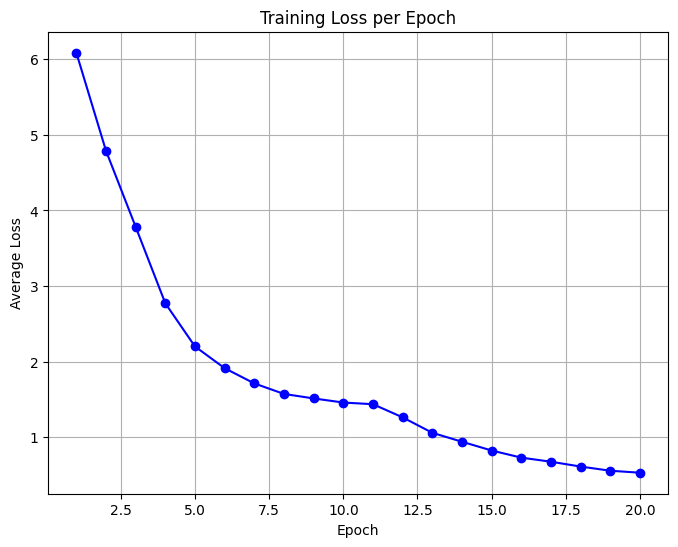

In [34]:
# Q. 위의 코드를 활용하여 모델을 훈련시켜봅시다!
import matplotlib.pyplot as plt

epoch_losses = []

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count, desc=f"Epoch {epoch+1}")
    
    for batch, (src, tgt) in enumerate(train_dataset):
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += loss
        tqdm_bar.set_description(f"Epoch {epoch+1} Loss: {loss.numpy():.4f}")
        tqdm_bar.update(1)
    
    tqdm_bar.close()
    avg_loss = total_loss / dataset_count
    epoch_losses.append(avg_loss.numpy())
    print(f"Epoch {epoch+1} 평균 손실: {avg_loss:.4f}")

# 에폭별 평균 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

In [35]:
# 챗봇 응답 생성 함수 (greedy decoding)
def chat_response(sentence, model, word2idx, idx2word, max_len_enc, max_len_dec):
    # 입력이 리스트라면 문자열로 변환
    if isinstance(sentence, list):
        sentence = " ".join(sentence)

    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    # 간단한 토큰화 (이미 전처리된 문장은 공백 기준 분리)
    tokens = sentence.split()
    # 단어를 인덱스로 변환 (없으면 <unk>로 처리)
    input_ids = [word2idx.get(token, word2idx["<unk>"]) for token in tokens]
    # 인코더 입력 벡터로 패딩 (배치 크기 1)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences([input_ids], maxlen=max_len_enc, padding='post')
    encoder_input = tf.convert_to_tensor(input_ids)
    
    # 디코더 입력 초기화 (<start> 토큰)
    decoder_input = [word2idx["<start>"]]
    
    for i in range(max_len_dec):
        # 현재 디코더 입력을 max_len_dec에 맞춰 패딩
        dec_input_padded = tf.keras.preprocessing.sequence.pad_sequences([decoder_input], maxlen=max_len_dec, padding='post')
        dec_input_tensor = tf.convert_to_tensor(dec_input_padded)
        
        # 마스크 생성 (generate_masks 함수가 이미 정의되어 있다고 가정)
        enc_mask, combined_mask, dec_mask = generate_masks(encoder_input, dec_input_tensor)
        
        # 모델 예측 수행
        predictions, _, _, _ = model(encoder_input, dec_input_tensor, enc_mask, combined_mask, dec_mask)
        # predictions shape: (batch, sequence_length, vocab_size)
        # 현재 단계: decoder_input의 길이 - 1 (마지막 토큰의 위치)
        predicted_id = tf.argmax(predictions[0, len(decoder_input)-1]).numpy()
        
        # <end> 토큰이면 종료
        if predicted_id == word2idx["<end>"]:
            break
        
        # 예측된 토큰을 디코더 입력에 추가
        decoder_input.append(predicted_id)
    
    # 디코더 입력 중, 첫 번째 <start> 토큰 제외하고 단어로 변환
    response_tokens = [idx2word[idx] for idx in decoder_input[1:]]
    return " ".join(response_tokens)

In [36]:
# 인코더, 디코더의 최대 길이
enc_max_len = enc_ndarray.shape[1]
dec_max_len = dec_ndarray.shape[1]

# 테스트용 예문
test_queries = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

# 챗봇 응답 생성
responses = [chat_response(query, transformer, word2idx, idx2word, enc_max_len, dec_max_len) 
             for query in test_queries]

# 제출 형식에 맞게 결과 출력
print("\nTranslations")
for i, response in enumerate(responses, 1):
    print(f"> {i}. {response} <end>")

# 하이퍼파라미터 출력 함수
def print_hyperparameters(model):
    print("\nHyperparameters")
    print("> n_layers:", model.n_layers)
    print("> d_model:", model.d_model.numpy() if hasattr(model.d_model, "numpy") else model.d_model)
    print("> n_heads:", model.n_heads)
    print("> d_ff:", model.d_ff)
    print("> dropout:", model.do.rate)

print_hyperparameters(transformer)

# 훈련 파라미터 (학습 시 사용한 값)

print("\nTraining Parameters")
print("> Warmup Steps:", LearningRateScheduler.WARMUP_STEPS)
print("> Batch Size:", BATCH_SIZE)
print("> Epoch At:", EPOCHS)


Translations
> 1. 그게 무슨 부분 으로 착각 만 할 수 있어요 . <end>
> 2. 마음 이 것 건지 바쁜 까지 해보세요 . <end>
> 3. 그게 무슨 부분 이에요 . <end>
> 4. 그게 무슨 부분 으로 착각 만 할 수 있어요 . <end>

Hyperparameters
> n_layers: 3
> d_model: 512.0
> n_heads: 8
> d_ff: 2048
> dropout: 0.2

Training Parameters
> Warmup Steps: 3000
> Batch Size: 64
> Epoch At: 20


In [37]:
import random
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 무작위로 2000개 샘플 추출
def sample_random_data(que_corpus, ans_corpus, sample_size=2000):
    """
    전체 토큰화된 질문(que_corpus)과 정답(ans_corpus)에서 무작위로 sample_size개 샘플을 추출합니다.
    
    que_corpus, ans_corpus: 토큰화된 문장 리스트들 (예: [['12시', '땡', '!'], ...])
    sample_size: 추출할 샘플 수 (기본 2000)
    
    Returns:
      sampled_questions: 선택된 질문(토큰 리스트)
      sampled_answers: 선택된 정답(토큰 리스트)
    """
    total_samples = min(len(que_corpus), len(ans_corpus))
    sample_size = sample_size if total_samples >= sample_size else total_samples
    sample_indices = random.sample(range(total_samples), sample_size)
    
    sampled_questions = [que_corpus[i] for i in sample_indices]
    sampled_answers   = [ans_corpus[i] for i in sample_indices]
    return sampled_questions, sampled_answers

# 샘플 데이터 추출
sampled_questions, sampled_answers = sample_random_data(que_corpus, ans_corpus, sample_size=2000)
print("샘플 추출 완료: {}개".format(len(sampled_questions)))

샘플 추출 완료: 2000개


In [38]:
# 학습된 모델로 샘플 질문에 대해 응답 생성 (chat_response 함수 사용)
# chat_response 함수는 입력 문자열을 받아 챗봇 응답(문자열)을 반환
generated_responses = []
for question in tqdm(sampled_questions, desc="Generating responses"):
    # 질문은 토큰 리스트이므로 문자열로 변환
    question_str = " ".join(question)
    response_str = chat_response(question_str, transformer, word2idx, idx2word, enc_max_len, dec_max_len)
    generated_responses.append(response_str)

# BLEU Score 계산
smooth_fn = SmoothingFunction().method1
bleu_scores = []
# 샘플 정답(sampled_answers)은 토큰 리스트 그대로 사용, 모델 응답은 문자열이므로 split() 처리
for ref_tokens, candidate_str in tqdm(zip(sampled_answers, generated_responses),
                                       total=len(generated_responses),
                                       desc="Computing BLEU scores"):
    candidate_tokens = candidate_str.split()
    score = sentence_bleu([ref_tokens], candidate_tokens, smoothing_function=smooth_fn)
    bleu_scores.append(score)

avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print("Random sample Average BLEU Score: {:.4f}".format(avg_bleu))


Generating responses:   0%|          | 0/2000 [00:00<?, ?it/s]

Computing BLEU scores:   0%|          | 0/2000 [00:00<?, ?it/s]

Random sample Average BLEU Score: 0.5826


## 회고
일단 mecab 설치하는 부분에서 시간이 너무 오래걸렸다.   
결국 설치도 못하고.. okt로 바꿨지만..   
다른 사람들은 어떻게 설치하셨을지 궁금하다.   
그리고 BLEU score 계산할 때도 엄청 걸리던데 다른 분들은 어떻게 하셨는지 궁금하다.   
난 결국 2000개 랜덤으로 추출해서 점수를 계산하는 방법을 선택했다.   
그리고 원래 이렇게 오래 걸리는 지 궁금하다.  
생각보다 시간이 너무 오래 걸려서 많은 실험을 하지는 못했지만 두 번째 실험 결과 BLEU score가 0.5를 넘겨서 너무 기분이 좋았다.   
근데 예문 결과는 썩 별로라서... 뭔가 더 살펴봐야 될 것 같지만 이만 마무리하겠다...   
그동안 했던 프로젝트 노드 중에서 거의 처음으로 성과를 확인할 수 있었던 노드라서 너무 기쁘다.   
추후 좀 더 면밀하게 뜯어봐야겠다.   
